In [1]:
import numpy as np
import plotly.graph_objects as go

# Purpose of this Notebook

## From Euler Angle Visualization Notebook
- Define Rotation Matrices
  
- Define a 'initialize_ref_frame' to generate reference frames

- Define a 'rotation apply' which details how to sequentially add successive rotation for symmetric and asymmetric Euler Angle Sets

- Define a 'setup_animation_scene' which sets up the animation sequence with sliders for effective presentation

- Define a 'set_small_to_zero' function that sets float point values that are extremely small to zero in a matrix for clean presentation of DCMs

- Define 'euler_rotation_animation' function that uses all of the previous functions to generate the animation shocasing the sequential rotations

## Functions Newly Defined for this Notebook
- 'rotation_matrix_to_prv' to convert a given DCM to an equivalent Axis-Angle / PRV

- 'prv_to_rotation_matrix' to convert a PRV to DCM

- 'PRV_rotation_animation' that usees previous function generate animation showcasing the rotation with a defined PRV.

In [2]:
'''
The definitions of Rotation Matrices
--------------------------------------------------------------------------------------------------------------------------------------------------------
    - The rotation abt the 1st principle axis (x-axis) is defined by the angle 'psi'
    - The rotation abt the 2nd principle axis (y-axis) is defined by the angle 'theta'
    - The rotation abt the 3rd principle axis (z-axis) is defined by the angle 'phi'
'''

def rotation_matrix_x(phi):
    """Generate rotation matrix for a roll (rotation about the x-axis)"""
    phi = np.radians(phi)
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[1, 0, 0], 
                     [0, c, s], 
                     [0, -s, c]])

def rotation_matrix_y(theta):
    """Generate rotation matrix for a pitch (rotation about the y-axis)"""
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, -s], 
                     [0, 1, 0], 
                     [s, 0, c]])

def rotation_matrix_z(psi):
    """Generate rotation matrix for a yaw (rotation about the z-axis)"""
    psi = np.radians(psi)
    c, s = np.cos(psi), np.sin(psi)
    return np.array([[c, s, 0], 
                     [-s, c, 0], 
                     [0, 0, 1]])

In [3]:
def rotation_matrix_to_prv(C):
    """
    Converts a rotation matrix to a Principal Rotation Vector (PRV).

    Args:
        C (np.array): A 3x3 rotation matrix.

    Returns:
        tuple: A PRV represented as (e_vector, phi_angle).
    """
    # Compute the angle phi from the trace of the rotation matrix
    trace_C = np.trace(C)
    phi = np.arccos((trace_C - 1) / 2)
    
    # Handle edge cases where phi is 0 or π
    if np.isclose(phi, 0) or np.isclose(phi, np.pi):
        
        # For phi=0, no rotation, the axis can be arbitrary, choose x-axis for simplicity
        # For phi=π, rotation by 180 degrees, find axis by identifying non-zero component
        e = np.array([1, 0, 0])  # Arbitrary axis, could also check for non-diagonal elements
    
    else:
        # Compute the unit vector e from the off-diagonal elements of the matrix C
        e = (1 / (2 * np.sin(phi))) * np.array([C[1, 2] - C[2, 1],
                                                C[2, 0] - C[0, 2],
                                                C[0, 1] - C[1, 0]])
        # Normalize the unit vector to ensure it's a valid unit vector
        e /= np.linalg.norm(e)

    # Ensure the angle phi is in the range [0, 2*pi)
    phi = np.mod(phi, 2 * np.pi)

    return e, phi

In [4]:
def prv_to_rotation_matrix(e, phi_deg):
    """
    Converts a Principal Rotation Vector (PRV) to a rotation matrix.

    Args:
        e (np.array)   : The unit vector of the PRV.
        phi_deg (float): The rotation angle of the PRV in degrees.

    Returns:
        np.array: A 3x3 rotation matrix.
    """
    # Convert the angle from degrees to radians
    phi_rad = np.radians(phi_deg)
    
    # Calculate the cosine and sine of the angle
    c_phi = np.cos(phi_rad)
    s_phi = np.sin(phi_rad)
    
    # Calculate the matrix Sigma
    Sigma = 1 - c_phi

    # Ensure e is a float array to avoid UFuncTypeError during in-place operations
    e = np.array(e, dtype=float)
    
    # Normalize e vector to ensure it's a valid unit vector
    e /= np.linalg.norm(e)
    
    # Decompose the unit vector into its components
    e1, e2, e3 = e
    
    # Construct the rotation matrix using the given formula
    C = np.array([[((e1**2)*Sigma + c_phi), (e1*e2*Sigma + e3*s_phi), (e1*e3*Sigma - e2*s_phi)],
                  [(e2*e1*Sigma - e3*s_phi), ((e2**2)*Sigma + c_phi), (e2*e3*Sigma + e1*s_phi)],
                  [(e3*e1*Sigma + e2*s_phi), (e3*e2*Sigma - e1*s_phi), ((e3**2)*Sigma + c_phi)]])

    return C

In [5]:
def initialize_frame(fig, frame_matrix, frame_label, colors, is_static=False):
    """
    Initializes vectors on the provided figure as either static or dynamic using a color dictionary.

    Args:
        fig (plotly.graph_objects.Figure) : The figure on which to add the frames.
        frame_matrix (np.ndarray)         : The matrix representing the orientation of the frame.
        frame_label (str)                 : Base label for the frame vectors ('N' for N-frame, 'E' for E-frame).
        colors (dict)                     : Dictionary of colors for each vector, keyed by 'i', 'j', 'k'.
        is_static (bool)                  : Indicates whether the frame should be added as static (with dotted lines).
        
    Note:
    - This function modifies the 'fig' (Figure object) directly. 
      In Python, objects like lists, dictionaries, and classes such as plotly.graph_objects.Figure are mutable. 
      This means they can be changed after creation. 
      `initialize_frame` leverages this by adding traces directly to 'fig', thus altering its state without the need to return a new object.
    
    - The function operates with a side effect: it changes the state of 'fig' by adding traces. 
      It does not return a value because its primary purpose is to modify the existing figure, not produce a new output. 
      This approach avoids the need for managing a return value, simplifying its usage and integration into other parts of your code.
    
    - By not returning a value, it is evident that the function's sole responsibility is to modify the provided figure, 
      aligning with typical practices in Plotly where in-place modifications are common for updating visual properties.

    """
    
    line_style = 'dot' if is_static else 'solid'
    
    suffix = " (static)" if is_static else ""
    
    axis_labels = ['i', 'j', 'k']  # Axis labels corresponding to 'i', 'j', 'k'

    for i, axis in enumerate(axis_labels):
        vec = frame_matrix[:, i]
        name = f'{frame_label}_{axis}{suffix}'
        color = colors[axis]  # Access color using axis label as key
        fig.add_trace(go.Scatter3d(x=[0, vec[0]], 
                                   y=[0, vec[1]], 
                                   z=[0, vec[2]],
                                   mode='lines+markers', 
                                   name=name,
                                   marker=dict(color=color),
                                   line=dict(dash=line_style, color=color)))

In [6]:
def setup_animation_scene(fig, frames, title):
    """
    Adds animation controls and configures layout settings for a Plotly figure.

    Args:
        fig (plotly.graph_objects.Figure): The figure to which the controls will be added.
        frames (list): List of animation frames to be included in the slider control.
        title (str): The title to set for the animation scene.

    Note:
    - Animation Controls: This function sets up interactive controls that allow users to play through or step through the animation frames at their own pace. 
                          The 'Play' button starts the animation, while the slider allows users to jump to specific points in the animation.
    
    - Button Configuration: The 'Play' button is configured to start the animation immediately when clicked, using the 'immediate' mode. 
                            It ensures that the animation runs smoothly, redrawing each frame with a duration of 100 milliseconds.
    
    - Slider Mechanism: The slider below the animation includes steps corresponding to each frame created in the animation sequence. 
                        Users can move the slider to navigate to different frames, which is particularly useful for examining specific moments of the animation in detail.
    
    - Current Value Display: The slider also shows the current frame number as the animation plays, 
                             providing immediate visual feedback to users on their current position within the animation sequence.
    
    - Layout Configuration: The function also defines the visual layout of the 3D scene. 
                            It sets a fixed cube aspect for the axes to ensure that objects in the 3D space are displayed proportionally. 
                            The axes are configured to not auto-scale, maintaining consistent spatial references.
    
    - Scene Dimensions: The overall dimensions of the figure are set to ensure sufficient space for viewing the animation comfortably, enhancing the visual experience for the user.
    
    - Usability and Interactivity: By integrating these controls, the function enhances the usability and interactivity of the visualization, 
                                   making it a more effective tool for presentations or educational purposes where step-by-step analysis of movements is beneficial.

    """
    # Update the figure with animation controls
    fig.update_layout(updatemenus=[{"type": "buttons",
                                    "showactive": False,
                                    "y": -0.13,
                                    "x": -0.02,
                                    "xanchor": 'left',
                                    "yanchor": 'bottom',
                                    "buttons": [{"label": 'Play',
                                                 "method": 'animate',
                                                 "args": [None, {"frame": {"duration": 100, "redraw": True},
                                                                 "fromcurrent": True,
                                                                 "mode": 'immediate'}]}]}],
                      sliders=[{"steps": [{"method": 'animate',
                                           "args": [[f.name], {"mode": 'immediate', 
                                                               "frame": {"duration": 100, "redraw": True},
                                                               "fromcurrent": True}],
                                           "label": str(k)} for k, f in enumerate(frames)],
                                "x": 0.1,
                                "y": 0,
                                "currentvalue": {"visible": True, "prefix": 'Step: '}}])

    # Set additional layout settings for the 3D scene
    fig.update_layout(width=1000,
                      height=800,
                      template='presentation',
                      scene={"aspectmode": 'cube',
                             "xaxis": {"range": [-1, 1], "autorange": False},
                             "yaxis": {"range": [-1, 1], "autorange": False},
                             "zaxis": {"range": [-1, 1], "autorange": False}},
                      title=f"{title}")

Axis-Angle (degrees): [0.429577, 0.867729, 0.250019], 80.3385
----------------------------------------------------
DCM:
[[ 0.32139328  0.55667089 -0.76604431]
 [ 0.06372507  0.79441497  0.60402315]
 [ 0.94479917 -0.24294521  0.21984574]]
----------------------------------------------------
Euler Angles (321 sequence): <60.00006220988052, 49.99998810012322, 70.00005924826925>


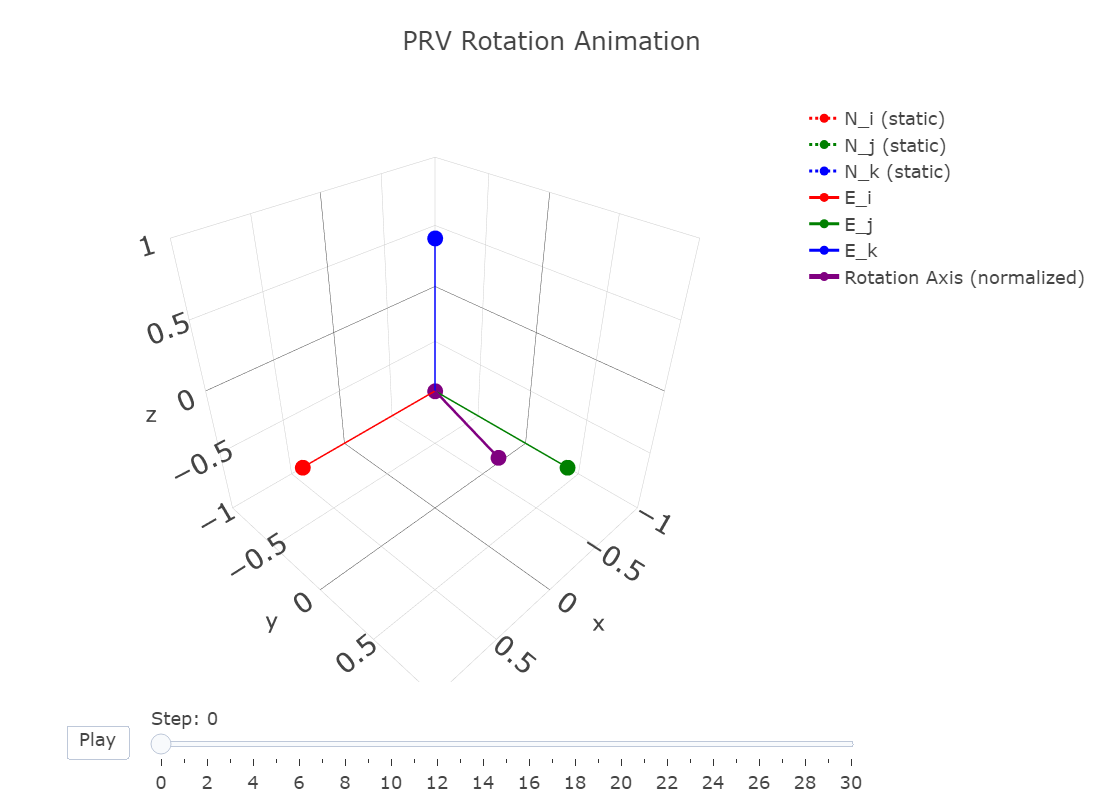

In [16]:
def PRV_rotation_animation(axis, angle, steps=30):
    """
    Creates a 3D animation of a rotation about a principal rotation vector (PRV) and displays the final orientation of the frame.

    Args:
        axis (list, tuple, np.ndarray): The unit vector representing the axis of rotation.
        angle (float): The magnitude of the rotation about the axis in degrees.
        steps (int, optional): The total number of steps in the animation. Defaults to 30.

    Returns:
        plotly.graph_objects.Figure: The figure object containing the animation.

    Notes:
    - The function dynamically calculates rotation matrices for each step based on the PRV method.
      It applies these rotations to an initial orientation matrix to visually represent these orientations in a Plotly figure.
    
    - This approach aids in visualizing the rotation from a starting point of no rotation, making it intuitive to understand complex rotational dynamics.
    
    - The animation controls allow for interactive exploration of the rotation sequence, enhancing the educational and analytical value of the visualization.
    """
    # Initialize the figure for 3D visualization
    fig = go.Figure()

    # Define initial orientation as an identity matrix
    N_frame = np.eye(3)

    # Define colors for axes and the rotation axis visualization
    colors = {'i': 'red', 
              'j': 'green', 
              'k': 'blue', 
              'axis': 'purple'}

    # Initialize the static frame (N-frame)
    initialize_frame(fig, N_frame, 'N', colors, is_static=True)

    # Initialize the dynamic frame (E-frame) to visualize rotations
    initialize_frame(fig, N_frame, 'E', colors, is_static=False)

    # Compute rotation matrix for each step using the PRV to rotation matrix conversion
    rotation_matrices = []
    for step in range(steps + 1):
        # Calculate the interpolation angle for the current step
        interpolated_angle = (step / steps) * angle
        # Use the prv_to_rotation_matrix function to generate the rotation matrix
        R_matrix = prv_to_rotation_matrix(axis, interpolated_angle)
        rotation_matrices.append(R_matrix)

    # Printing relevant Attitude representations
    # Euler angles are representative of 3-2-1 sequence
    DCM = rotation_matrices[-1]
    first_rot = np.degrees(np.arctan2(DCM[0][1], DCM[0][0]))
    second_rot = np.degrees(np.arcsin(-DCM[0][2]))
    third_rot = np.degrees(np.arctan2(DCM[1][2], DCM[2][2]))
    
    print(f"Axis-Angle (degrees): {axis}, {angle}")
    print("----------------------------------------------------")
    print(f"DCM:\n{DCM}")
    print("----------------------------------------------------")
    print(f"Euler Angles (321 sequence): <{first_rot}, {second_rot}, {third_rot}>")

    # Generate frames for animation
    frames = []
    for i, R_matrix in enumerate(rotation_matrices):
        
        E_frame = np.matmul(R_matrix, N_frame)

        # List of frames
        frame_data = [go.Scatter3d(x=[0, vec[0]], 
                                   y=[0, vec[1]], 
                                   z=[0, vec[2]],
                                   mode='lines+markers',
                                   name=f'E_{chr(105+j)}',
                                   marker=dict(color=colors['i' if j == 0 else 'j' if j == 1 else 'k']))for j, vec in enumerate(E_frame)]


        frames.append(go.Frame(data=frame_data, name=str(i), traces=[3, 4, 5]))

    # Calculate the norm of the axis
    axis_norm = np.linalg.norm(axis)
    
    # Plot the rotation axis as a line extending from the origin
    axis_normalized = axis / np.array(axis_norm)
    fig.add_trace(go.Scatter3d(x=[0, axis_normalized[0]], 
                               y=[0, axis_normalized[1]], 
                               z=[0, axis_normalized[2]],
                               mode='lines+markers',
                               line=dict(color=colors['axis'], width=5),
                               name='Rotation Axis (normalized)'))

    # Configure the figure with generated frames for animation
    fig.frames = frames
    setup_animation_scene(fig, frames, "PRV Rotation Animation")

    return fig

# Example usage
axis = [0.429577, 0.867729, 0.250019]  
angle = 80.3385  
fig = PRV_rotation_animation(axis, angle)
fig.show()
